# CryptoCurrency Price Prediction

SUMMARY

Blockchain technology is a decentralized database system that was first implemented by Bitcoin. Created by a mysterious person (or group), Blockchain has a very high tendency to transform modern day business operation models. As Bitcoin gains more traction, people keep coming up with alternate coins that are also based on Blockchain technology.

Initial Questions:-

1.   What affects the crypto price?
2.   When Bitcoin spikes, does every other coin spike? 
3.   Does social media affect crypto prices?

The goal is to find a model where we can predit the value of Cryptocoin considering all the factors which influences the price.


APPROACH:

1. Initial Data Exploration (Data Wrangling): 
   a. Compare multiple coins to see if there's a corelation in the price. 
      Used CryptoCompare.com to get daily (hourly) price data for different coins.For now, only 'BTC', 'ETH' is considered.
   b. Get google trends using Pytrends API, search = 'CryptoCurrency' to see how it affects price.
   c. Twitter sentiment analysis to see how it affects price
      
 Employ Python technologies to import and inspect the raw data, isolate relevant variables, calculate new variables, 
 organize the dataframe, and resolve missing, invalid, corrupted or duplicate values. 

 Begin creating data visualizations to inspect variables and analyze outliers.
   
   
2. Exploratory Data Analysis: 
   Continue with data visualization, using plots to gain insights, look for correlations, consider a hypothesis to explore,  then leverage statistical inference to test the hypothesis.
   Included factors that infuence Bitcoin price:-
    a.  Analyze other cryptocurrencies to see if there's a correlation (CompareCoins.ipynb)
    b.  Analyze Reddit Metrics(Reddit Metrics.ipynb)
    c.  Analyze Google trends(Google trends.ipynb)
    d.  Analyze Stock Market Prices(Stock Market.ipynb)
    e.  Analyze Commodity Prices(Commodity.ipynb)
    f.  Analyze Oil Prices(Oil Prices.ipynb)

3. Machine Learning Analysis: Apply (to-be-determined) machine learning algorithms, evaluating the performance of each, and decide on the right one to use for this study.

4. Final Reports & Presentations


DATA SOURCES:

1. CryptoCompare
2. Quandl 
3. Google Trends using Pytrends API
4. Twitter data using API
5. Stock Market Prices
6. Commodity Prices
7. Oil Prices
8. Reddit Metrics



In [171]:
# Getting price data of BTC and ETH using Cryptocompare API

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Indicate how many rows of data here
lim = '10000' 
crypto_coin = ['BTC', 'ETH']
crypto_data = pd.DataFrame()
for i in crypto_coin:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
   
    data = requests.get(URL)
    json_data = data.json()

    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index,unit='s')  #UNIX Epoch time
    crypto_data = pd.concat([crypto_data, table.high], axis=1)  ### Take just the 'High' column for a coin
crypto_data.columns = crypto_coin

In [172]:
#Read the first 5 records
crypto_data.head(5)

,BTC,ETH
time,,
2018-01-30 16:00:00,10491.16,1123.15
2018-01-30 17:00:00,10489.18,1124.42
2018-01-30 18:00:00,10257.49,1098.50
2018-01-30 19:00:00,10372.25,1096.46
2018-01-30 20:00:00,10301.59,1095.24


In [173]:
#Read the last 5 records
crypto_data.tail(5)

,BTC,ETH
time,,
2018-04-23 20:00:00,8959.90,639.82
2018-04-23 21:00:00,8963.21,640.64
2018-04-23 22:00:00,8976.09,643.54
2018-04-23 23:00:00,8969.62,644.16
2018-04-24 00:00:00,8988.30,647.28


In [174]:
# Getting data from Google Trends using Pytrends API
from pytrends.request import TrendReq
# Login to Google. Only need to run this once
pytrend = TrendReq()
# Create payload and capture API tokens. 
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 4 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe='2018-01-01 2018-04-23')  

crypto_ggtrends = pytrend.interest_over_time()

# Upsampling daily data to hourly data
crypto_ggtrends = crypto_ggtrends.resample('1h').pad().drop(['isPartial'], axis='columns')
crypto_ggtrends.columns = ['SearchFrequency']


In [175]:
print(crypto_ggtrends.head(5))

                     SearchFrequency
date                                
2018-01-01 00:00:00               14
2018-01-01 01:00:00               14
2018-01-01 02:00:00               14
2018-01-01 03:00:00               14
2018-01-01 04:00:00               14


In [176]:
print(crypto_ggtrends.tail(5))

                     SearchFrequency
date                                
2018-04-20 20:00:00                9
2018-04-20 21:00:00                9
2018-04-20 22:00:00                9
2018-04-20 23:00:00                9
2018-04-21 00:00:00                9


In [177]:
# Joining two data frames

crypto_combined = pd.concat([crypto_data, crypto_ggtrends], axis=1).dropna(how='any')   ### Remove NaN 
crypto_combined_s = crypto_combined.copy(deep=True)
print(crypto_combined_s.head(5))

                          BTC      ETH  SearchFrequency
time                                                   
2018-01-30 16:00:00  10491.16  1123.15             26.0
2018-01-30 17:00:00  10489.18  1124.42             26.0
2018-01-30 18:00:00  10257.49  1098.50             26.0
2018-01-30 19:00:00  10372.25  1096.46             26.0
2018-01-30 20:00:00  10301.59  1095.24             26.0


In [178]:
# Feature Scaling. This will capture trend information and makes visualization more meaningful

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
crypto_combined_s['BTC'] = sc_x.fit_transform(crypto_combined_s['BTC'].values.reshape(-1,1))
crypto_combined_s['ETH'] = sc_x.fit_transform(crypto_combined_s['ETH'].values.reshape(-1,1))
crypto_combined_s['SearchFrequency'] = sc_x.fit_transform(crypto_combined_s['SearchFrequency'].values.reshape(-1,1))

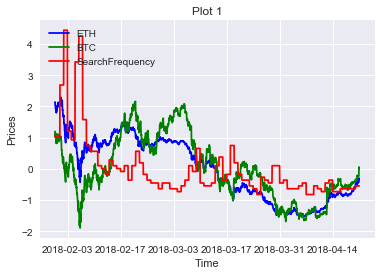

In [179]:
# Plot 1- scaled overlay plot of ETH/BTC prices 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(crypto_combined_s.index, crypto_combined_s['ETH'], color='blue')
plt.plot(crypto_combined_s.index, crypto_combined_s['BTC'], color='green')
plt.plot(crypto_combined_s.index, crypto_combined_s['SearchFrequency'], color='red')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Plot 1')
plt.show()

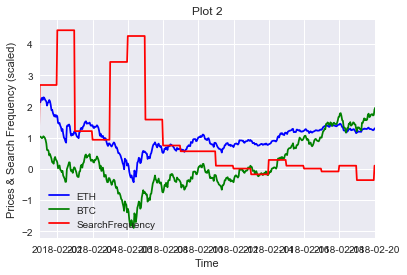

In [180]:
# Plot 2- scaled overlay plot of ETC/BTC prices and GoogleNews search frequency data in 20 days timespand (during drop)

plt.plot(crypto_combined_s.index, crypto_combined_s['ETH'], color='blue')
plt.plot(crypto_combined_s.index, crypto_combined_s['BTC'], color='green')
plt.plot(crypto_combined_s.index, crypto_combined_s['SearchFrequency'], color='red')
plt.xlim(('2018-02-01', '2018-02-20'))
plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 2')
plt.show()



In [112]:
import re
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        #tweet = re.sub(r'RT', '', tweet)
        return (' '.join(re.sub("(RT @[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) )

In [113]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

tweets_data_df = pd.read_json('2018_Apr_19_20_Tweets.json', orient = 'records', lines = True)

tweets_df = pd.DataFrame()
tweets_df['created_at'] = pd.to_datetime(tweets_data_df['created_at'])
tweets_df['text'] = tweets_data_df['text']
analyser = SentimentIntensityAnalyzer()
pos = []
neg = []
neu = []
comp = []


for index, row in tweets_df.iterrows():
    snt = analyser.polarity_scores(clean_tweet(row['text']))
    pos.append(snt['pos'])
    neg.append(snt['neg'])
    neu.append(snt['neu'])
    comp.append(snt['compound'])
    
tweets_df['pos_snt'] = pos   
tweets_df['neg_snt'] = neg 
tweets_df['neu_snt'] = neu 
tweets_df['comp_snt'] = comp 

In [114]:
tweets_df.head(3)

,created_at,text,pos_snt,neg_snt,neu_snt,comp_snt
0,2018-04-20 23:59:59,RT @datareum: We are listed on: https://t.co/4...,0.000,0.0,1.000,0.0000
1,2018-04-20 23:59:59,RT @Aruwba: I'm growing a bush 😽 Come see the ...,0.102,0.0,0.898,0.1779
2,2018-04-20 23:59:58,Live improvisé ! Let's talk about Bitcoin http...,0.000,0.0,1.000,0.0000


In [115]:
tweets_df.tail(3)

,created_at,text,pos_snt,neg_snt,neu_snt,comp_snt
5779,2018-04-18 23:20:23,RT @syscoin: #Syscoin 3.0 RC2 released to #Tes...,0.0,0.000,1.000,0.0000
5780,2018-04-18 23:20:21,Telegram’s Pavel Durov Is Using Bitcoin to Byp...,0.0,0.000,1.000,0.0000
5781,2018-04-18 23:20:20,Lathan Warlick – Kill It https://t.co/2KzaMec7...,0.0,0.485,0.515,-0.6908


In [116]:
df_new = tweets_df.groupby(tweets_df['created_at'].dt.to_period('D'))['pos_snt','neg_snt','neu_snt','comp_snt'].agg(['sum'])
df_new

,pos_snt,neg_snt,neu_snt,comp_snt
,sum,sum,sum,sum
created_at,,,,
2018-04-18,195.117,122.673,1706.218,140.0759
2018-04-19,175.060,72.779,1629.152,210.7927
2018-04-20,192.303,82.121,1606.592,248.4064


In [117]:
import quandl
price_data_df=[]

In [118]:
# Read data into a DataFrame
price_data_df = quandl.get('BCHARTS/KRAKENUSD', start_date="2018-04-18", end_date="2018-04-20")

In [134]:
price_data_df

price_data_df.set_index='Date'
price_data_df.index = price_data_df.index.to_period(freq='D')

price_data_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 3 entries, 2018-04-18 to 2018-04-20
Freq: D
Data columns (total 7 columns):
Open                 3 non-null float64
High                 3 non-null float64
Low                  3 non-null float64
Close                3 non-null float64
Volume (BTC)         3 non-null float64
Volume (Currency)    3 non-null float64
Weighted Price       3 non-null float64
dtypes: float64(7)
memory usage: 192.0 bytes


In [148]:
df_new.index.names = ['Date']
df_new


,pos_snt,neg_snt,neu_snt,comp_snt
,sum,sum,sum,sum
Date,,,,
2018-04-18,195.117,122.673,1706.218,140.0759
2018-04-19,175.060,72.779,1629.152,210.7927
2018-04-20,192.303,82.121,1606.592,248.4064


In [145]:
price_data_df

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-04-18,7893.0,8308.0,7865.0,8170.0,5577.110378,4.503784e+07,8075.479888
2018-04-19,8170.6,8308.0,8099.7,8275.7,3584.325377,2.945564e+07,8217.902645
2018-04-20,8267.5,8943.8,8226.0,8875.0,7749.022485,6.604851e+07,8523.463234


In [150]:
combined_df = pd.concat([df_new, price_data_df],axis=1)

In [151]:
combined_df.columns=['Pos','Neg','Neu','Comp','Open','High','Low','Close','Volume','Currency','Price']

In [152]:
combined_df

,Pos,Neg,Neu,Comp,Open,High,Low,Close,Volume,Currency,Price
Date,,,,,,,,,,,
2018-04-18,195.117,122.673,1706.218,140.0759,7893.0,8308.0,7865.0,8170.0,5577.110378,4.503784e+07,8075.479888
2018-04-19,175.060,72.779,1629.152,210.7927,8170.6,8308.0,8099.7,8275.7,3584.325377,2.945564e+07,8217.902645
2018-04-20,192.303,82.121,1606.592,248.4064,8267.5,8943.8,8226.0,8875.0,7749.022485,6.604851e+07,8523.463234


In [163]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2018-04-18 to 2018-04-20
Freq: D
Data columns (total 11 columns):
Pos         3 non-null float64
Neg         3 non-null float64
Neu         3 non-null float64
Comp        3 non-null float64
Open        3 non-null float64
High        3 non-null float64
Low         3 non-null float64
Close       3 non-null float64
Volume      3 non-null float64
Currency    3 non-null float64
Price       3 non-null float64
dtypes: float64(11)
memory usage: 288.0 bytes


In [164]:
combined_df.index = combined_df.index.to_datetime()

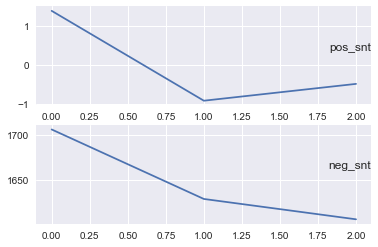

In [165]:
values = combined_df.values
# specify columns to plot
groups = [ 1,2]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [169]:
# Feature Scaling. This will capture trend information and makes visualization more meaningful

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
combined_df['Pos'] = sc_x.fit_transform(combined_df['Pos'].values.reshape(-1,1))
combined_df['Neg'] = sc_x.fit_transform(combined_df['Neg'].values.reshape(-1,1))
combined_df['Price'] = sc_x.fit_transform(combined_df['Price'].values.reshape(-1,1))
combined_df['Volume'] = sc_x.fit_transform(combined_df['Volume'].values.reshape(-1,1))

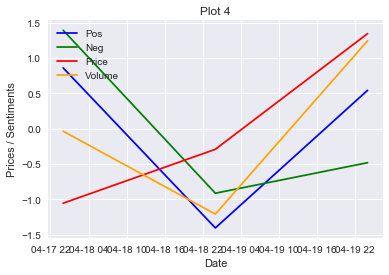

In [170]:
# Plot 4- scaled overlay plot of Date & Sentiments /BTC prices/Volume 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(combined_df.index, combined_df['Pos'], color='blue')
plt.plot(combined_df.index, combined_df['Neg'], color='green')
plt.plot(combined_df.index, combined_df['Price'], color='red')
plt.plot(combined_df.index, combined_df['Volume'], color='orange')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Prices / Sentiments')
plt.title('Plot 4')
plt.show()